In [ ]:
!pip install pyvis


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks
import pickle

import networkx as nx
from pyvis.network import Network

ModuleNotFoundError: No module named 'pyvis'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
root = "/content/drive/MyDrive/TreeHacks2025/ppg_exports_20241126_094919/"

In [3]:
metadata_df = pd.read_csv(os.path.join(root, "metadata.csv"), on_bad_lines="skip")

# Signals to Metadata

In [4]:
os.listdir(root)

['.DS_Store', 'metadata.csv', 'regular', 'afib', 'irregular', 'unclassified']

In [5]:
metadata_df["filename"].apply(lambda x: x[:x.index("_")]).unique()

array(['regular', 'irregular', 'afib'], dtype=object)

In [6]:
id_to_metadata = {metadata_df["filename"].iloc[i]: metadata_df.iloc[i,:-1].values for i in range(metadata_df.shape[0])}

In [7]:
outcomes = ['regular', 'afib', 'irregular']
all_data_paths = {i: [] for i in outcomes}
for outcome in outcomes:
  for f in os.listdir(root + outcome):
    all_data_paths[outcome].append(root + outcome + "/" + f)

In [8]:
metadata_df[metadata_df["filename"].str.startswith("regular")].shape[0]

1000

In [9]:
len(os.listdir(root + "regular"))

997

In [26]:
# all_signals = []
# all_outcomes = []
all_ids = []
for outcome, file_list in all_data_paths.items():
  count = 0
  for f in file_list:
    if count % 100 == 0:
      print(count)
    if f[f.rindex("/")+1:min(f.rindex(" ") if " " in f else float("inf"), f.rindex("."))] + ".csv" in id_to_metadata:
      all_ids.append(f[f.rindex("/")+1:min(f.rindex(" ") if " " in f else float("inf"), f.rindex("."))] + ".csv")
    count += 1

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
1000
0
100
200
300
400
500
600
700
800
900


In [ ]:
all_signals = []
all_outcomes = []
all_ids = []
for outcome, file_list in all_data_paths.items():
  count = 0
  for f in file_list:
    if count % 100 == 0:
      print(count)
    try:
      all_outcomes.append(id_to_metadata[f[f.rindex("/")+1:min(f.rindex(" ") if " " in f else float("inf"), f.rindex("."))] + ".csv"])
      df = pd.read_csv(f, on_bad_lines="skip")
      all_signals.append(df.iloc[:,:-1].values.T)
      all_ids.append(f)
    except:
      pass
    count += 1

0


In [367]:
all_ids

[]

In [ ]:
# pickle.dump(all_signals, open("all_signals.dat", "wb"))
# pickle.dump(all_outcomes, open("all_outcomes.dat", "wb"))

In [27]:
all_signals = pickle.load(open("/content/drive/MyDrive/TreeHacks2025/all_signals.dat", "rb"))
all_outcomes = pickle.load(open("/content/drive/MyDrive/TreeHacks2025/all_outcomes.dat", "rb"))

In [11]:
def moving_average(data, window_size):
  cumsum = np.cumsum(data, axis=1)
  cumsum[:, window_size:] = cumsum[:, window_size:] - cumsum[:, :-window_size]
  return cumsum[:, window_size - 1:] / window_size

In [12]:
all_signals = [moving_average(i, 100) for i in all_signals]

In [19]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len):
    super().__init__()
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    self.pe = pe.unsqueeze(0)  # Shape: [1, max_len, d_model]

  def forward(self, x):
    return x + self.pe[:, :x.size(1)].to(x.device)

# class TransformerRegressor(nn.Module):
#     def __init__(self, input_dim, time_steps, output_dim, d_model=128, nhead=4, num_layers=3, dim_feedforward=256, dropout=0.1):
#         super().__init__()
#         self.input_proj = nn.Linear(input_dim, d_model)
#         self.pos_encoder = PositionalEncoding(d_model, max_len=time_steps)
#         encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, activation='gelu', batch_first=True, norm_first=True)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
#         self.pool = nn.AdaptiveAvgPool1d(1)  # Global pooling over time dimension
#         self.fc_out = nn.Linear(d_model, output_dim)
#         self.layer_norm = nn.LayerNorm(d_model)

#     def forward(self, x, mask):
#         # x shape: [batch_size, num_features, time_steps]
#         x = x.permute(0, 2, 1)  # Shape -> [batch_size, time_steps, num_features]
#         x = self.input_proj(x)  # Shape -> [batch_size, time_steps, d_model]
#         x = self.pos_encoder(x)
#         x = self.transformer_encoder(x, src_key_padding_mask=mask)
#         x = self.layer_norm(x)
#         x = x.permute(0, 2, 1)  # Shape -> [batch_size, d_model, time_steps]
#         x = self.pool(x).squeeze(-1)  # Shape -> [batch_size, d_model]
#         x = self.fc_out(x)  # Shape -> [batch_size, output_dim]
#         return x

In [20]:
class TransformerRegressor(nn.Module):
  def __init__(self, input_dim, time_steps, output_dim, d_model=64, nhead=4, num_layers=3, dim_feedforward=128, dropout=0.4):
    super().__init__()
    self.input_proj = nn.Linear(input_dim, d_model)
    self.pos_encoder = PositionalEncoding(d_model, max_len=time_steps)

    # Encoder Layer with residuals within each layer
    encoder_layers = nn.TransformerEncoderLayer(
      d_model=d_model,
      nhead=nhead,
      dim_feedforward=dim_feedforward,
      dropout=dropout,
      activation="gelu",
      batch_first=True,
      # norm_first=True
    )
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

    # Additional residual connections for attention and feed-forward parts
    self.layer_norm_before_attention = nn.LayerNorm(d_model)
    self.layer_norm_after_attention = nn.LayerNorm(d_model)

    self.pool = nn.AdaptiveAvgPool1d(1)  # Global pooling over time dimension
    self.fc_out = nn.Linear(d_model, output_dim)

    # Add additional layers or dropout
    self.fc_intermediate = nn.Linear(d_model, d_model)  # Intermediate linear layer for additional transformation
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask):
    x = x.permute(0, 2, 1)  # Shape -> [batch_size, time_steps, num_features]
    x = self.input_proj(x)  # Shape -> [batch_size, time_steps, d_model]
    x = self.pos_encoder(x)

    # Residual connections around the attention part
    residual = x
    x = self.transformer_encoder(x, src_key_padding_mask=mask)
    x = residual + x  # Adding residual from original input
    x = self.layer_norm_before_attention(x)

    # Residual around feedforward layer
    residual_ff = x
    x = self.layer_norm_after_attention(x)
    x = self.fc_intermediate(x)  # Intermediate transformation
    x = torch.relu(x)  # Activation
    x = self.dropout(x)
    x = residual_ff + x  # Adding residual from attention layer

    x = self.pool(x.permute(0, 2, 1)).squeeze(-1)  # Shape -> [batch_size, d_model]
    x = self.fc_out(x)  # Shape -> [batch_size, output_dim]
    return x

In [21]:
class TimeSeriesDataset(Dataset):
  def __init__(self, sequences, targets, max_time):
    self.max_time = max_time
    self.padded_sequences = []
    self.masks = []
    self.targets = torch.tensor(targets, dtype=torch.float32)

    for seq in sequences:
      seq_tensor = torch.tensor(seq, dtype=torch.float32)  # Convert numpy array to tensor
      pad_length = max_time - seq_tensor.shape[1]
      padded_seq = F.pad(seq_tensor, (0, pad_length), "constant", 0)
      mask = torch.zeros(max_time, dtype=torch.bool)
      mask[seq_tensor.shape[1]:] = True  # Mask padded positions

      self.padded_sequences.append(padded_seq)
      self.masks.append(mask)

    self.padded_sequences = torch.stack(self.padded_sequences)
    self.masks = torch.stack(self.masks)

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    return self.padded_sequences[idx], self.masks[idx], self.targets[idx]

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [23]:
all_outcomes = np.array(all_outcomes).astype(float)
all_outcomes_mean, all_outcomes_std = np.mean(all_outcomes, axis=0), np.std(all_outcomes, axis=0)
all_outcomes_norm = (all_outcomes - all_outcomes_mean) / all_outcomes_std

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [29]:
batch_size = 2
num_features = all_signals[0].shape[0]
output_dim = all_outcomes[0].shape[0]
max_time = max([seq.shape[1] for seq in all_signals])
model = TransformerRegressor(input_dim=num_features, time_steps=max_time, output_dim=output_dim)

dataset = TimeSeriesDataset(all_signals, all_outcomes_norm, max_time)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

ValueError: num_samples should be a positive integer value, but got num_samples=0

In [25]:
val_size = int(0.03 * len(dataset))
train_size = int(0.1 * len(dataset))
_size = len(dataset) - val_size - train_size
# _size = len(dataset) - val_size - train_size
train_dataset, val_dataset, _ = random_split(dataset, [train_size, val_size, _size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

NameError: name 'dataset' is not defined

In [118]:
model.to(device)

TransformerRegressor(
  (input_proj): Linear(in_features=6, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.4, inplace=False)
        (dropout2): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (layer_norm_before_attention): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (layer_norm_after_attention): LayerNorm((64,), eps=1e-05, elementwise_affin

In [119]:
sum([i.numel() for i in model.parameters()])

106190

In [120]:
def train_model(model, device, train_loader, val_loader, criterion, optimizer, epochs=100):
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_cos = 0.0
    for data, mask, target in train_loader:
      assert not mask.all(dim=1).any(), "Some samples are fully masked"
      data = data.to(device)
      mask = mask.to(device)
      target = target.to(device)
      means = torch.mean(data, dim=2, keepdim=True)
      stds = torch.std(data, dim=2, keepdim=True)
      data = (data - means) / stds
      optimizer.zero_grad()
      output = model(data, mask)
      loss = criterion(output, target)
      loss.backward()
      # for name, param in model.named_parameters():
      #   if param.grad is not None:
      #       print(f"Gradient for {name}: {param.grad.norm()}")  # Norm of the gradient
      #   else:
      #       print(f"Gradient for {name}: None")
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.8)
      optimizer.step()
      train_loss += loss.item()
      train_cos += torch.mean(F.cosine_similarity(output, target, dim=1))

    train_loss /= len(train_loader)
    train_cos /= len(train_loader)

    model.eval()
    val_loss = 0.0
    val_cos = 0.0
    with torch.no_grad():
      for data, mask, target in val_loader:
        data = data.to(device)
        mask = mask.to(device)
        target = target.to(device)
        means = torch.mean(data, dim=2, keepdim=True)
        stds = torch.std(data, dim=2, keepdim=True)
        data = (data - means) / stds
        output = model(data, mask)
        loss = criterion(output, target)
        val_loss += loss.item()
        val_cos += torch.mean(F.cosine_similarity(output, target, dim=1))

    val_loss /= len(val_loader)
    val_cos /= len(val_loader)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Cos Sim: {train_cos:.4f} - Val Loss: {val_loss:.4f} - Val Cos Sim: {val_cos:.4f}")

In [121]:
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

train_model(model, device, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch 1/100 - Train Loss: nan - Train Cos Sim: nan - Val Loss: nan - Val Cos Sim: nan


KeyboardInterrupt: 

In [ ]:
# use more data
# increase learning rate

In [ ]:
# torch.save(model.state_dict(), "overfitted_model.pt")

In [ ]:
# a, b, c = next(iter(train_loader))
a, b, c = next(iter(val_loader))
a, b = a.to(device), b.to(device)
means = torch.mean(a, dim=2, keepdim=True)
stds = torch.std(a, dim=2, keepdim=True)
a = (a - means) / stds
pred = model(a, b)

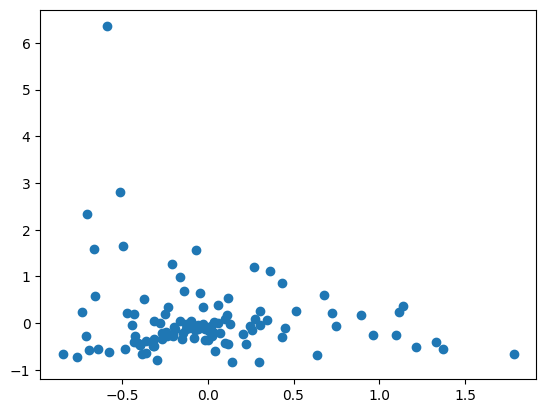

In [ ]:
plt.scatter(pred.flatten().cpu().detach().numpy(), c.flatten().cpu().detach().numpy())

# Downstream Functionalities

In [ ]:
outcomes

['regular', 'afib', 'irregular']

In [58]:
class SquadMonitor():
  def __init__(self, squad_signals, squad_metadata, soldier_IDs,
               signal_feature_names, metadata_feature_names, model, device, model_info, disease_classifier, label_encoder,
               lime_training_data):
    self.squad_signals = squad_signals
    self.squad_metadata = squad_metadata
    self.soldier_IDs = soldier_IDs
    self.signal_feature_names = signal_feature_names
    self.metadata_feature_names = metadata_feature_names
    # "model" is a trained model that generates metadata predictions from raw signals
    self.model = model.to(device)
    self.device = device

    # contains :
    # - maximum time steps that the model was trained on
    # - metadata mean per feature
    # - metadata std per feature
    self.model_info = model_info

    # trained logistic regression that predicts ["afib", "regular", "irregular"] from metadata
    self.disease_classifier = disease_classifier
    # fitted label encoder that maps from outcome to label encoding
    self.label_encoder = label_encoder

    self.explainer = lime_tabular.LimeTabularExplainer(
      training_data=lime_training_data,
      feature_names=self.metadata_feature_names,
      class_names=["afib", "irregular", "regular"],
      mode="classification"
    )

    self.activity_distribution = np.array(self.generate_background_activity())
    self.health_distribution = self.generate_background_health()

  def generate_background_activity(self):
    temp = []
    for signal in self.squad_signals:
      acc_x = signal[self.signal_feature_names.index("acc_x")]
      acc_y = signal[self.signal_feature_names.index("acc_y")]
      acc_z = signal[self.signal_feature_names.index("acc_z")]
      VM = (acc_x ** 2 + acc_y ** 2 + acc_z ** 2) ** 0.5
      temp.append(max(VM) - min(VM))
    return temp

  def generate_background_health(self):
    return self.disease_classifier.predict_proba(self.squad_metadata)[:,2]

  # Generate_metadata for sequences (list of num_features, num_timesteps numpy arrays)
  def generate_metadata(self, sequences, soldier_IDs):
    padded_sequences = []
    masks = []
    for seq in sequences:
      seq_tensor = torch.tensor(seq, dtype=torch.float32)  # Convert numpy array to tensor
      pad_length = self.model_info["max_time"] - seq_tensor.shape[1]
      padded_seq = F.pad(seq_tensor, (0, pad_length), "constant", 0)
      mask = torch.zeros(self.model_info["max_time"], dtype=torch.bool)
      mask[seq_tensor.shape[1]:] = True  # Mask padded positions
      padded_sequences.append(padded_seq)
      masks.append(mask)
    padded_sequences = torch.tensor(padded_sequences, dtype=torch.float32).to(self.device)
    masks = torch.tensor(masks, dtype=torch.float32).to(self.device)
    outputs = model(padded_sequences, masks)
    outputs = outputs.cpu().detach().numpy()

    # un-normalize
    outputs = outputs * self.model_info["metadata_std"] + self.model_info["metadata_mean"]
    return pd.DataFrame(outputs, columns=self.metadata_feature_names, index=soldier_IDs)

  def visualize_one_metadata(self, one_soldier_metadata):
    # can do some percentile stuff on the front end
    pass

  def visualize_all_metadata(self, all_soldier_metadata):
    # can do some distribution stuff on the front end
    pass

  def generate_heart_metrics(self, sequences, soldier_IDs):
    # heart rate
    # mean RR interval
    # std of RR intervals
    # RMS of successive differences (SD)

    interval = 40e-3 # hard-coded 40 millisecond interval because ~1500 timesteps per minute

    green_idx = self.signal_feature_names.index("green")
    heart_rates = []
    mean_RRs = []
    std_RRs = []
    RMSSDs = []
    for seq, id in zip(sequences, soldier_IDs):
      peaks, _ = find_peaks(seq[green_idx], height=0)
      bpm = []
      for i in range(len(peaks)):
        bpm.append(1500 / peaks[i] * i)
      bpm = bpm[peaks[0]:]
      heart_rates.append(bpm)
      RR_intervals = np.diff(peaks) * interval
      mean_RRs.append(np.mean(RR_intervals))
      std_RRs.append(np.std(RR_intervals))
      RMSSDs.append(np.mean(np.diff(RR_intervals) ** 2) ** 0.5)
    return pd.DataFrame({"Heart Rate": heart_rates,
                         "Mean RR Interval": mean_RRs,
                         "SDNN": std_RRs,
                         "RMSSD": RMSSDs}, index=soldier_IDs)

  def generate_health_predictions(self, metadata, soldier_IDs):
    if len(metadata) == 1:
      metadata = metadata.reshape(1,-1)
    outputs = self.disease_classifier.predict(metadata)
    probs = self.disease_classifier.predict_proba(metadata)[:,2]
    outputs = self.label_encoder.inverse_transform(outputs)
    percentiles = []
    for prob in probs:
      percentiles.append(np.sum(prob >= self.health_distribution) / self.health_distribution.shape[0])
    return {soldier_IDs[i]: (outputs[i], percentiles[i]) for i in range(len(soldier_IDs))}

  def generate_movement_data(self, signals, soldier_IDs):
    VM_range_percentiles = []
    for signal in signals:
      acc_x = signal[self.signal_feature_names.index("acc_x")]
      acc_y = signal[self.signal_feature_names.index("acc_y")]
      acc_z = signal[self.signal_feature_names.index("acc_z")]
      VM = (acc_x ** 2 + acc_y ** 2 + acc_z ** 2) ** 0.5
      VM_range = max(VM) - min(VM)
      VM_range_percentile = np.sum(VM_range >= self.activity_distribution) / self.activity_distribution.shape[0]
      VM_range_percentiles.append(VM_range_percentile)
    return {soldier_IDs[i]: VM_range_percentiles[i] for i in range(len(soldier_IDs))}

  def optimize_cohort(self, cohort_metadata, cohort_IDs):
    all_outcomes = self.generate_health_predictions(self.squad_metadata, self.soldier_IDs)
    cohort_outcomes = self.generate_health_predictions(cohort_metadata, cohort_IDs)
    self.visualize_cohort(cohort_outcomes)

    cohort_outcomes_class = [i[0] for i in cohort_outcomes.values()]
    num_regular = cohort_outcomes_class.count("regular")
    num_irregular = cohort_outcomes_class.count("irregular")
    num_afib = cohort_outcomes_class.count("afib")

    if num_irregular > 0 or num_afib > 0:
      self.alert_commander(num_irregular, num_afib)
      healthy_replacements = [ID for ID, condition in all_outcomes.items() if condition[0] == "regular" and not ID in cohort_IDs]
      sampled_replacements = np.random.choice(healthy_replacements, size=num_irregular + num_afib, replace=False)
      to_replace = [ID for ID, condition in cohort_outcomes.items() if condition[0] != "regular"]
      for i in to_replace:
        cohort_IDs.remove(i)
      for i in sampled_replacements:
        cohort_IDs.append(i)
      return cohort_IDs
    return cohort_IDs

  def optimize_cohort2(self, cohort_metadata, cohort_IDs):
    all_outcomes = self.generate_health_predictions(self.squad_metadata, self.soldier_IDs)
    location_ids = np.random.choice(list(range(len(self.soldier_IDs)//5)), size=len(self.soldier_IDs))
    locations_unique = [(int(1000*np.random.rand()), int(1000*np.random.rand())) for i in range(len(self.soldier_IDs)//5)]
    locations = [locations_unique[i] for i in location_ids]
    loc_temp = (int(1000*np.random.rand()), int(1000*np.random.rand()))
    for i in range(len(self.soldier_IDs)):
      if self.soldier_IDs[i] in cohort_IDs:
        locations[i] = loc_temp
    keys = self.soldier_IDs
    graph_data = {keys[i]:{"location":locations[i], "health":all_outcomes[keys[i]][1]} for i in range(len(keys))}
    location_target = locations_unique[0]
    threshold = 0.9
    target_soldiers = {p: d for p, d in graph_data.items() if tuple(d["location"]) == location_target}
    below_threshold = {p for p, d in target_soldiers.items() if d["health"] < threshold}

    healthy_soldiers = {p: d for p, d in graph_data.items() if d["health"] >= threshold and tuple(d["location"]) != location_target}

    def distance(loc1, loc2):
        return (loc1[0] - loc2[0]) ** 2 + (loc1[1] - loc2[1]) ** 2

    # Greedy algorithm which minimizes the distance that you would have to move healthy troops from other locations to get them to be at location_target
    # The output should be a list of tuples (person_a, person_b), where person_a is the person to be replaced, and person_b is the person replacing them.
    total_cost = 0
    relocation_plan = []
    for soldier in below_threshold:
        if not healthy_soldiers:
            break  # No more healthy soldiers to move

        # Find the closest healthy soldier
        closest_replacement = min(healthy_soldiers, key=lambda s: distance(tuple(healthy_soldiers[s]["location"]), location_target))
        total_cost += distance(tuple(healthy_soldiers[closest_replacement]["location"]), location_target)

        # Record the move
        relocation_plan.append((soldier, closest_replacement))

        # Remove the moved soldier from available replacements
        del healthy_soldiers[closest_replacement]

    # Output the final relocation plan
    print(relocation_plan)
    print(total_cost)

    locations = {tuple(d["location"]) for d in graph_data.values()}
    donor_locations = {tuple(graph_data[p]["location"]) for _, p in relocation_plan}
    # Assign colors based on role
    colors = {}
    for loc in locations:
        if loc == location_target:
            colors[loc] = "green"  # Target location
        elif loc in donor_locations:
            colors[loc] = "red"    # Donor locations
        else:
            colors[loc] = "blue"   # Other locations

    # Plot locations
    plt.figure(figsize=(8, 6))
    for loc, color in colors.items():
        plt.scatter(loc[0], loc[1], color=color, s=200, edgecolors="black", label=color if color not in plt.gca().get_legend_handles_labels()[1] else "")

    # Labels and aesthetics
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Soldier Relocation Visualization")
    plt.legend(["Target (Green)", "Donor (Red)", "Neutral (Blue)"])
    plt.grid(True)
    plt.show()

    # Create NetworkX graph
    G = nx.Graph()

    # Add nodes with colors
    for loc in locations:
        G.add_node(loc, color=colors[loc])

    # Add edges for relocations
    edges = []
    edge_labels = {}
    for donor, receiver in relocation_plan:
        donor_loc = tuple(graph_data[donor]["location"])
        target_loc = tuple(graph_data[receiver]["location"])

        # Ensure the order of the tuple is consistent: donor -> receiver
        edge_tuple = (donor_loc, target_loc) if donor_loc < target_loc else (target_loc, donor_loc)

        G.add_edge(donor_loc, target_loc)
        edges.append((donor_loc, target_loc))
        edge_labels[edge_tuple] = edge_labels.get(edge_tuple, "") + f"{donor} → {receiver} "

    # --- Matplotlib Visualization ---
    plt.figure(figsize=(8, 6))
    pos = {loc: loc for loc in locations}  # Position nodes based on coordinates
    node_colors = [colors[n] for n in G.nodes]

    nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color="black", node_size=1000, font_size=8, font_weight="bold")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, font_color="red")

    plt.title("Relocation Graph with Transfers")
    plt.show()

    # --- Pyvis (Interactive Web Visualization) ---
    nt = Network('500px', '500px', notebook=True)
    for node in G.nodes:
        node_id = str(node)  # Convert the tuple to a string
        nt.add_node(node_id, color=colors[node], title=str(node))  # Add tooltips

    # Then, when adding edges to the graph, make sure the correct order is followed:
    for edge in G.edges:
        edge_tuple = (edge[0], edge[1]) if edge[0] < edge[1] else (edge[1], edge[0])
        label = edge_labels.get(edge_tuple, "")
        nt.add_edge(str(edge[0]), str(edge[1]), title=label)  # Ensure edge ordering

    nt.show("nx.html")

  def visualize_cohort(self, cohort_outcomes):
    # can visualize cohort outcomes on the front end
    pass

  def alert_commander(self, num_irregular, num_afib):
    # can do some front end thing
    pass

  def explain_outcome(self, metadata_row):
    exp = self.explainer.explain_instance(
      data_row=metadata_row,
      predict_fn=self.disease_classifier.predict_proba, num_features=len(self.metadata_feature_names))
    features = exp.as_map()
    exp.show_in_notebook()
    # figure out visualization on front end

  def end_to_end(self, signals, soldier_IDs):
    predicted_metadata = self.generate_metadata(signals, soldier_IDs)
    outcome_predictions = self.generate_health_predictions(predicted_metadata.values, soldier_IDs)
    return outcome_predictions


In [14]:
! pip install lime
import lime
from lime import lime_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=a4f2f75e63821659a80a8017722fb69c0319536e1e44b20eee8999afac61705a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
explainer = lime_tabular.LimeTabularExplainer(
  training_data=X_t,
  feature_names=metadata.columns[:-1],
  class_names=['afib', 'irregular', 'regular'],
  mode='classification'
)

In [ ]:
exp = explainer.explain_instance(
  data_row=X_t[0],
  predict_fn=lr.predict_proba, num_features=metadata.shape[1]-1)
features = exp.as_map()

In [ ]:
features

{1: [(9, 0.3888633160848863),
  (7, 0.252287642182239),
  (0, 0.10605764268875444),
  (12, 0.04407371779960847),
  (4, 0.03515865532954507),
  (10, 0.02300107563277357),
  (3, 0.01914274224731643),
  (2, -0.014973211260360551),
  (1, -0.014190255384781318),
  (8, -0.00857460621375065),
  (6, 0.007548561747493725),
  (5, 0.0067390514085869015),
  (11, -0.003076654511757938),
  (13, -0.0007773277287316069)]}

In [ ]:
le.inverse_transform(lr.predict(X_t[0].reshape(1,-1)))

array(['irregular'], dtype=object)

In [ ]:
exp.show_in_notebook()

In [64]:
[i for i in metadata_df["filename"].apply(lambda x: x[:-4]).tolist() if " " in i]

[]

In [70]:
metadata_df[metadata_df["filename"].isin(all_ids)]

,sinus,bradycardia,tachycardia,brady_episode,increased_hrv,tachy_episode,atrial_flutter,atrial_fibrillation,extrasystoles_bigminy,extrasystoles_frequent,extrasystoles_isolated,extrasystoles_trigeminy,extrasystoles_big_episode,extrasystoles_trig_episode,filename
0,0.792743,0.010405,0.012852,0.009979,0.046365,0.013038,0.012176,0.011995,0.011067,0.009181,0.037293,0.011029,0.010773,0.011105,regular_1.csv
1,0.302839,0.009541,0.012640,0.010040,0.545251,0.012761,0.008074,0.006429,0.008243,0.010104,0.048075,0.008127,0.009295,0.008582,regular_2.csv
2,0.569893,0.012372,0.013917,0.013252,0.228312,0.015489,0.010631,0.012475,0.011948,0.013415,0.062736,0.011165,0.012777,0.011620,regular_3.csv
3,0.825582,0.010987,0.013214,0.012482,0.012836,0.011228,0.013625,0.010001,0.013409,0.010215,0.028495,0.013385,0.011172,0.013370,regular_4.csv
4,0.442336,0.006235,0.007689,0.023287,0.271213,0.107267,0.006277,0.011201,0.005997,0.011480,0.082505,0.008485,0.008647,0.007381,regular_5.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,0.007291,0.016905,0.014899,0.017576,0.008997,0.009946,0.010364,0.662542,0.014208,0.106506,0.022909,0.016955,0.066198,0.024705,afib_1082.csv
3067,0.016358,0.012422,0.017076,0.010606,0.009574,0.010221,0.007033,0.514755,0.008476,0.259231,0.031878,0.008579,0.066631,0.027161,afib_1083.csv
3068,0.005709,0.006447,0.008279,0.006227,0.005396,0.009490,0.010926,0.500329,0.007334,0.359576,0.027223,0.012281,0.033738,0.007046,afib_1084.csv
3069,0.007545,0.007251,0.012610,0.006026,0.003363,0.006604,0.010950,0.850752,0.011204,0.055747,0.007350,0.013249,0.003176,0.004173,afib_1085.csv


In [92]:
all_signals_set = []
for i in all_signals:
    # Check if the array is unique by comparing with already added arrays
    if not any(np.array_equal(i, x) for x in all_signals_set):
        all_signals_set.append(i)

In [89]:
unique_signals = remove_duplicate_arrays(all_signals)

TypeError: 'set' object does not support item assignment

In [93]:
len(all_signals_set)

2970

In [71]:
len(set(all_ids))

2972

In [96]:
[i for i in all_ids if "(" in i]

[]

In [34]:
len(all_signals)

3003

In [37]:
metadata_df.shape

(3071, 15)

In [140]:
metadata_df

,sinus,bradycardia,tachycardia,brady_episode,increased_hrv,tachy_episode,atrial_flutter,atrial_fibrillation,extrasystoles_bigminy,extrasystoles_frequent,extrasystoles_isolated,extrasystoles_trigeminy,extrasystoles_big_episode,extrasystoles_trig_episode,filename
0,0.792743,0.010405,0.012852,0.009979,0.046365,0.013038,0.012176,0.011995,0.011067,0.009181,0.037293,0.011029,0.010773,0.011105,regular_1.csv
1,0.302839,0.009541,0.012640,0.010040,0.545251,0.012761,0.008074,0.006429,0.008243,0.010104,0.048075,0.008127,0.009295,0.008582,regular_2.csv
2,0.569893,0.012372,0.013917,0.013252,0.228312,0.015489,0.010631,0.012475,0.011948,0.013415,0.062736,0.011165,0.012777,0.011620,regular_3.csv
3,0.825582,0.010987,0.013214,0.012482,0.012836,0.011228,0.013625,0.010001,0.013409,0.010215,0.028495,0.013385,0.011172,0.013370,regular_4.csv
4,0.442336,0.006235,0.007689,0.023287,0.271213,0.107267,0.006277,0.011201,0.005997,0.011480,0.082505,0.008485,0.008647,0.007381,regular_5.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,0.007291,0.016905,0.014899,0.017576,0.008997,0.009946,0.010364,0.662542,0.014208,0.106506,0.022909,0.016955,0.066198,0.024705,afib_1082.csv
3067,0.016358,0.012422,0.017076,0.010606,0.009574,0.010221,0.007033,0.514755,0.008476,0.259231,0.031878,0.008579,0.066631,0.027161,afib_1083.csv
3068,0.005709,0.006447,0.008279,0.006227,0.005396,0.009490,0.010926,0.500329,0.007334,0.359576,0.027223,0.012281,0.033738,0.007046,afib_1084.csv
3069,0.007545,0.007251,0.012610,0.006026,0.003363,0.006604,0.010950,0.850752,0.011204,0.055747,0.007350,0.013249,0.003176,0.004173,afib_1085.csv


In [67]:
sm = SquadMonitor(squad_signals=all_signals, squad_metadata=metadata_df.iloc[:,:-1].values, soldier_IDs=all_ids, signal_feature_names=["green", "red", "IR", "acc_x", "acc_y", "acc_z"],
                  metadata_feature_names=metadata.columns[:-1], model=model, device=device,
                  model_info=model_info, disease_classifier=lr, label_encoder=le, lime_training_data=X_t)

[('irregular_914.csv', 'regular_897.csv'), ('regular_605.csv', 'regular_764.csv'), ('regular_856.csv', 'regular_675.csv'), ('afib_250.csv', 'regular_347.csv')]
7982


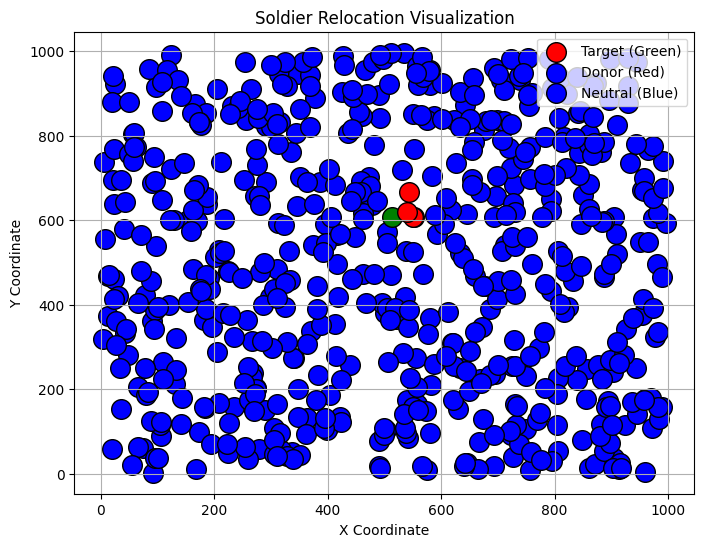

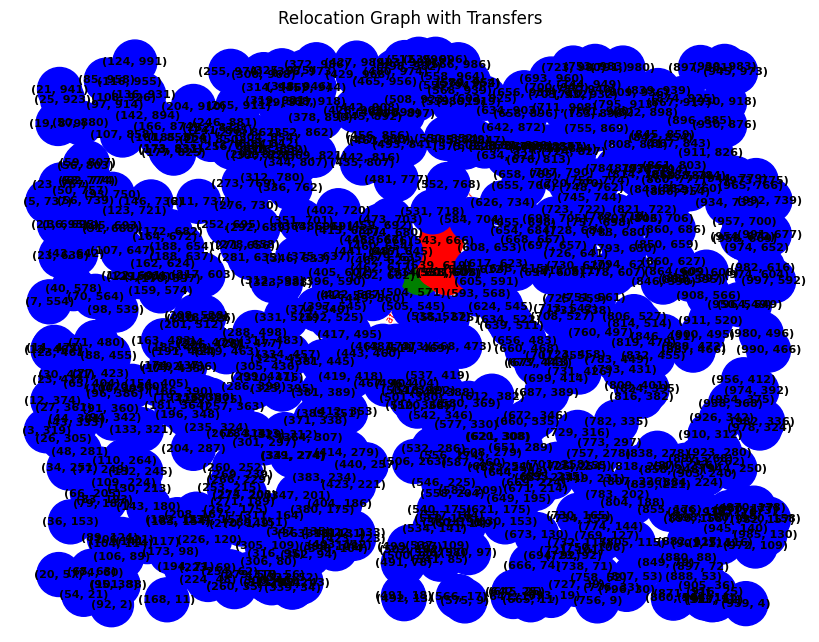

nx.html


In [68]:
sm.optimize_cohort2(metadata_df.iloc[1000:1010,:-1].values, metadata_df.iloc[1000:1010,-1].values.tolist())

In [177]:
sm.health_distribution

array([9.86939644e-01, 9.37241756e-01, 9.70427039e-01, ...,
       1.78427274e-03, 6.49924940e-05, 2.93670824e-02])

In [178]:
metadata_df.iloc[1000:1010]

,sinus,bradycardia,tachycardia,brady_episode,increased_hrv,tachy_episode,atrial_flutter,atrial_fibrillation,extrasystoles_bigminy,extrasystoles_frequent,extrasystoles_isolated,extrasystoles_trigeminy,extrasystoles_big_episode,extrasystoles_trig_episode,filename
1000,0.041212,0.005270,0.011275,0.009485,0.024193,0.014119,0.014104,0.015023,0.006452,0.622377,0.211966,0.006649,0.010962,0.006912,irregular_1.csv
1001,0.010685,0.005754,0.006999,0.004719,0.008884,0.004068,0.005313,0.007846,0.007704,0.914093,0.001102,0.011543,0.007097,0.004194,irregular_2.csv
1002,0.012154,0.006838,0.014069,0.008349,0.005347,0.040049,0.072533,0.018703,0.010677,0.742039,0.034761,0.006367,0.020343,0.007771,irregular_3.csv
1003,0.006734,0.006839,0.004816,0.008774,0.023648,0.029250,0.006863,0.013653,0.008227,0.797562,0.054711,0.010272,0.020975,0.007676,irregular_4.csv
1004,0.012264,0.005630,0.010824,0.021600,0.009096,0.072513,0.035273,0.136547,0.003781,0.475403,0.029061,0.004411,0.146062,0.037536,irregular_5.csv
1005,0.272958,0.009336,0.012251,0.018448,0.040075,0.015471,0.009948,0.009678,0.007321,0.170489,0.127508,0.011894,0.283435,0.011189,irregular_6.csv
1006,0.006074,0.007867,0.008346,0.005020,0.006037,0.005925,0.009793,0.006908,0.009346,0.898772,0.003234,0.008311,0.011622,0.012744,irregular_7.csv
1007,0.020045,0.010672,0.008258,0.012480,0.178600,0.022856,0.004766,0.021200,0.010206,0.353632,0.330089,0.013243,0.005449,0.008503,irregular_8.csv
1008,0.001972,0.001531,0.001033,0.000887,0.001163,0.001054,0.003938,0.000499,0.000917,0.009169,0.002975,0.026834,0.000569,0.947460,irregular_9.csv
1009,0.004930,0.002355,0.005896,0.008880,0.006264,0.004101,0.004173,0.004504,0.439335,0.005905,0.002898,0.002522,0.505640,0.002598,irregular_10.csv


In [181]:
metadata_df.iloc[1000:1010,-1].values.tolist()

['irregular_1.csv',
 'irregular_2.csv',
 'irregular_3.csv',
 'irregular_4.csv',
 'irregular_5.csv',
 'irregular_6.csv',
 'irregular_7.csv',
 'irregular_8.csv',
 'irregular_9.csv',
 'irregular_10.csv']

In [161]:
metadata_df

,sinus,bradycardia,tachycardia,brady_episode,increased_hrv,tachy_episode,atrial_flutter,atrial_fibrillation,extrasystoles_bigminy,extrasystoles_frequent,extrasystoles_isolated,extrasystoles_trigeminy,extrasystoles_big_episode,extrasystoles_trig_episode,filename
0,0.792743,0.010405,0.012852,0.009979,0.046365,0.013038,0.012176,0.011995,0.011067,0.009181,0.037293,0.011029,0.010773,0.011105,regular_1.csv
1,0.302839,0.009541,0.012640,0.010040,0.545251,0.012761,0.008074,0.006429,0.008243,0.010104,0.048075,0.008127,0.009295,0.008582,regular_2.csv
2,0.569893,0.012372,0.013917,0.013252,0.228312,0.015489,0.010631,0.012475,0.011948,0.013415,0.062736,0.011165,0.012777,0.011620,regular_3.csv
3,0.825582,0.010987,0.013214,0.012482,0.012836,0.011228,0.013625,0.010001,0.013409,0.010215,0.028495,0.013385,0.011172,0.013370,regular_4.csv
4,0.442336,0.006235,0.007689,0.023287,0.271213,0.107267,0.006277,0.011201,0.005997,0.011480,0.082505,0.008485,0.008647,0.007381,regular_5.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,0.007291,0.016905,0.014899,0.017576,0.008997,0.009946,0.010364,0.662542,0.014208,0.106506,0.022909,0.016955,0.066198,0.024705,afib_1082.csv
3067,0.016358,0.012422,0.017076,0.010606,0.009574,0.010221,0.007033,0.514755,0.008476,0.259231,0.031878,0.008579,0.066631,0.027161,afib_1083.csv
3068,0.005709,0.006447,0.008279,0.006227,0.005396,0.009490,0.010926,0.500329,0.007334,0.359576,0.027223,0.012281,0.033738,0.007046,afib_1084.csv
3069,0.007545,0.007251,0.012610,0.006026,0.003363,0.006604,0.010950,0.850752,0.011204,0.055747,0.007350,0.013249,0.003176,0.004173,afib_1085.csv


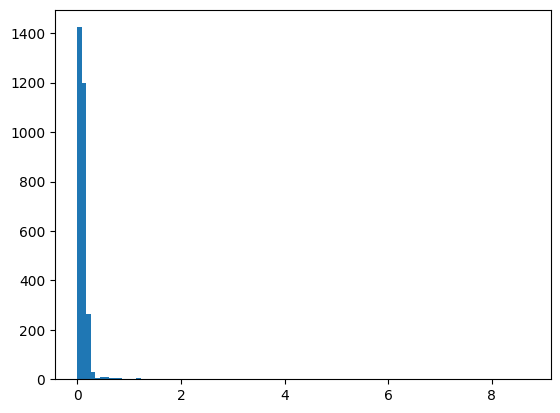

In [160]:
plt.hist(sm.activity_distribution, bins=100)
plt.show()

In [ ]:
sm.generate_heart_metrics([regular1.values.T], ["Regular 1"])

,Heart Rate,Mean RR Interval,SDNN,RMSSD
Regular 1,83,0.072488,0.034121,0.039015


In [31]:
model_info = {"max_time": max_time, "metadata_mean": all_outcomes_mean, "metadata_std": all_outcomes_std}

# Metadata to Outcome Variable

In [33]:
metadata = pd.read_csv("/content/drive/MyDrive/TreeHacks2025/ppg_exports_20241126_094919/metadata.csv", on_bad_lines="skip")

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [35]:
X = metadata.iloc[:,:-1].values
y = metadata.iloc[:,-1].apply(lambda x: x[:x.index("_")])
# y = pd.get_dummies(y).values
le = LabelEncoder()
y = le.fit_transform(y)

In [36]:
X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.5, stratify=y)

In [37]:
lr = LogisticRegression()
lr.fit(X_t, y_t)

LogisticRegression()

In [38]:
le.inverse_transform(lr.predict(X_v[0:1]))

array(['afib'], dtype=object)

In [39]:
accuracy_score(lr.predict(X_v), y_v)

0.982421875

In [40]:
train_dataset = TensorDataset(torch.tensor(X_t, dtype=torch.float32), torch.tensor(y_t, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_v, dtype=torch.float32), torch.tensor(y_v, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# Define the Feedforward Neural Network
class FeedforwardNN(nn.Module):
    def __init__(self, input_size=14, hidden_size=256, output_size=3):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x  # No softmax here as CrossEntropyLoss expects raw logits

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedforwardNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, axis=1)).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}%", end="\t")

    # Evaluate on test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == torch.argmax(labels, axis=1)).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50, Loss: 0.5911, Accuracy: 88.47%	Test Loss: 0.1470, Test Accuracy: 98.24%
Epoch 2/50, Loss: 0.0828, Accuracy: 98.57%	Test Loss: 0.0514, Test Accuracy: 98.44%
Epoch 3/50, Loss: 0.0438, Accuracy: 98.50%	Test Loss: 0.0367, Test Accuracy: 98.96%
Epoch 4/50, Loss: 0.0337, Accuracy: 98.83%	Test Loss: 0.0331, Test Accuracy: 98.89%
Epoch 5/50, Loss: 0.0285, Accuracy: 99.22%	Test Loss: 0.0350, Test Accuracy: 98.70%
Epoch 6/50, Loss: 0.0246, Accuracy: 99.35%	Test Loss: 0.0358, Test Accuracy: 98.83%
Epoch 7/50, Loss: 0.0238, Accuracy: 99.28%	Test Loss: 0.0286, Test Accuracy: 99.09%
Epoch 8/50, Loss: 0.0213, Accuracy: 99.22%	Test Loss: 0.0289, Test Accuracy: 98.96%
Epoch 9/50, Loss: 0.0205, Accuracy: 99.35%	Test Loss: 0.0281, Test Accuracy: 98.96%
Epoch 10/50, Loss: 0.0161, Accuracy: 99.67%	Test Loss: 0.0471, Test Accuracy: 98.18%
Epoch 11/50, Loss: 0.0194, Accuracy: 99.35%	Test Loss: 0.0371, Test Accuracy: 98.63%
Epoch 12/50, Loss: 0.0183, Accuracy: 99.41%	Test Loss: 0.0349, Test Accura

KeyboardInterrupt: 

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.45593596 0.26391546]


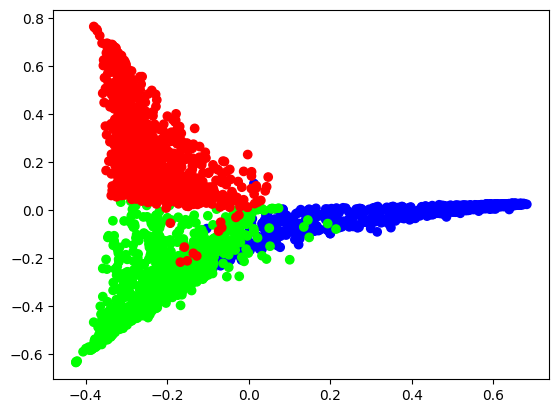

In [ ]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.show()

# Jai Sharma Section

In [ ]:
metadata_df = pd.read_csv(os.path.join(root, "metadata.csv"), on_bad_lines="skip")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
metadata_df

,sinus,bradycardia,tachycardia,brady_episode,increased_hrv,tachy_episode,atrial_flutter,atrial_fibrillation,extrasystoles_bigminy,extrasystoles_frequent,extrasystoles_isolated,extrasystoles_trigeminy,extrasystoles_big_episode,extrasystoles_trig_episode,filename
0,0.792743,0.010405,0.012852,0.009979,0.046365,0.013038,0.012176,0.011995,0.011067,0.009181,0.037293,0.011029,0.010773,0.011105,regular_1.csv
1,0.302839,0.009541,0.012640,0.010040,0.545251,0.012761,0.008074,0.006429,0.008243,0.010104,0.048075,0.008127,0.009295,0.008582,regular_2.csv
2,0.569893,0.012372,0.013917,0.013252,0.228312,0.015489,0.010631,0.012475,0.011948,0.013415,0.062736,0.011165,0.012777,0.011620,regular_3.csv
3,0.825582,0.010987,0.013214,0.012482,0.012836,0.011228,0.013625,0.010001,0.013409,0.010215,0.028495,0.013385,0.011172,0.013370,regular_4.csv
4,0.442336,0.006235,0.007689,0.023287,0.271213,0.107267,0.006277,0.011201,0.005997,0.011480,0.082505,0.008485,0.008647,0.007381,regular_5.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,0.007291,0.016905,0.014899,0.017576,0.008997,0.009946,0.010364,0.662542,0.014208,0.106506,0.022909,0.016955,0.066198,0.024705,afib_1082.csv
3067,0.016358,0.012422,0.017076,0.010606,0.009574,0.010221,0.007033,0.514755,0.008476,0.259231,0.031878,0.008579,0.066631,0.027161,afib_1083.csv
3068,0.005709,0.006447,0.008279,0.006227,0.005396,0.009490,0.010926,0.500329,0.007334,0.359576,0.027223,0.012281,0.033738,0.007046,afib_1084.csv
3069,0.007545,0.007251,0.012610,0.006026,0.003363,0.006604,0.010950,0.850752,0.011204,0.055747,0.007350,0.013249,0.003176,0.004173,afib_1085.csv


In [ ]:
regular1 = pd.read_csv("/content/drive/MyDrive/TreeHacks2025/ppg_exports_20241126_094919/regular/regular_1.csv")
regular2 = pd.read_csv("/content/drive/MyDrive/TreeHacks2025/ppg_exports_20241126_094919/regular/regular_2.csv")
irregular1 = pd.read_csv("/content/drive/MyDrive/TreeHacks2025/ppg_exports_20241126_094919/irregular/irregular_1.csv")
irregular2 = pd.read_csv("/content/drive/MyDrive/TreeHacks2025/ppg_exports_20241126_094919/irregular/irregular_2.csv")

In [ ]:
all_signals[0].shape

NameError: name 'all_signals' is not defined

In [ ]:
regular1

,green,red,IR,acc_x,acc_y,acc_z,sample_index
0,83047,195375,206703,8.081758,-4.426722,3.061617,1
1,82736,195216,206637,8.122436,-4.274778,3.016153,2
2,82606,195099,206647,8.154739,-4.313063,2.864209,3
3,82679,195065,206633,8.092526,-4.490132,2.958725,4
4,82876,195065,206603,8.114061,-4.381258,2.971886,5
...,...,...,...,...,...,...,...
1513,82903,192950,206866,7.908279,-4.543970,3.187240,1514
1514,83027,192981,206905,7.984849,-4.382455,3.093920,1515
1515,83142,193013,206954,7.953742,-4.496114,3.231507,1516
1516,83359,193050,206962,7.927421,-4.555934,3.141776,1517


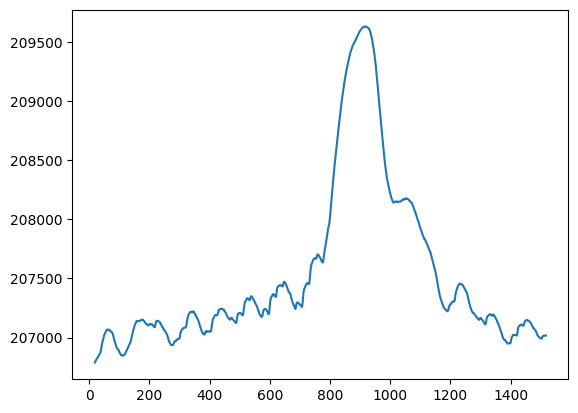

In [ ]:
plt.plot(regular1["IR"].rolling(20).mean())

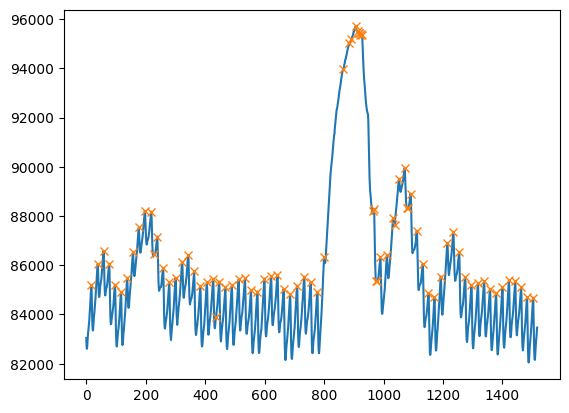

In [ ]:
peaks, _ = find_peaks(regular1["green"], height=0)
plt.plot(regular1["green"])
plt.plot(peaks, regular1["green"][peaks], "x")
# plt.plot(np.zeros_like(regular1["green"]), "--", color="gray")
plt.show()

In [ ]:
bpm = []
for i in range(len(peaks)):
  bpm.append(1500 / peaks[i] * i)
bpm = bpm[peaks[0]:]

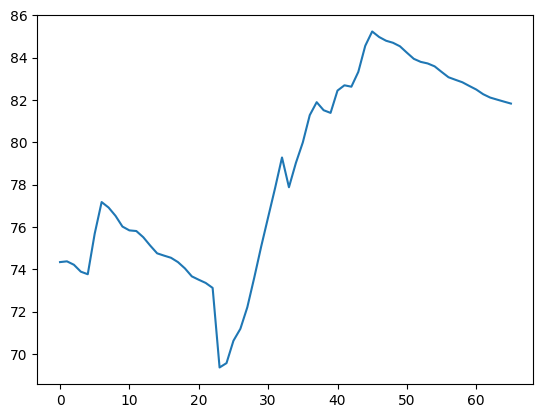

In [ ]:
plt.plot(bpm)

In [ ]:
timestamps = np.linspace(0,1500,11)
for i in range(len(timestamps) - 1):
  print(sum(np.logical_and(peaks >= timestamps[i], peaks < timestamps[i+1])) * 10)


70
80
90
70
60
60
150
100
70
70


In [ ]:
np.linspace(0,1500,11)

array([   0.,  150.,  300.,  450.,  600.,  750.,  900., 1050., 1200.,
       1350., 1500.])

In [ ]:
np.diff(peaks) * 4e-3

array([0.088, 0.076, 0.076, 0.076, 0.084, 0.084, 0.076, 0.08 , 0.08 ,
       0.088, 0.036, 0.044, 0.076, 0.084, 0.088, 0.088, 0.08 , 0.08 ,
       0.084, 0.088, 0.084, 0.036, 0.044, 0.084, 0.088, 0.092, 0.084,
       0.08 , 0.088, 0.092, 0.092, 0.084, 0.084, 0.088, 0.092, 0.096,
       0.088, 0.088, 0.092, 0.26 , 0.076, 0.032, 0.056, 0.032, 0.012,
       0.008, 0.012, 0.012, 0.008, 0.144, 0.02 , 0.028, 0.012, 0.044,
       0.092, 0.08 , 0.02 , 0.06 , 0.076, 0.036, 0.008, 0.036, 0.084,
       0.08 , 0.076, 0.08 , 0.088, 0.088, 0.08 , 0.076, 0.08 , 0.088,
       0.088, 0.08 , 0.08 , 0.084, 0.084, 0.088, 0.084, 0.08 , 0.08 ,
       0.08 ])

In [ ]:
peaks

array([  17,   39,   58,   77,   96,  117,  138,  157,  177,  197,  219,
        228,  239,  258,  279,  301,  323,  343,  363,  384,  406,  427,
        436,  447,  468,  490,  513,  534,  554,  576,  599,  622,  643,
        664,  686,  709,  733,  755,  777,  800,  865,  884,  892,  906,
        914,  917,  919,  922,  925,  927,  963,  968,  975,  978,  989,
       1012, 1032, 1037, 1052, 1071, 1080, 1082, 1091, 1112, 1132, 1151,
       1171, 1193, 1215, 1235, 1254, 1274, 1296, 1318, 1338, 1358, 1379,
       1400, 1422, 1443, 1463, 1483, 1503])

In [ ]:
regular1.columns

Index(['green', 'red', 'IR', 'acc_x', 'acc_y', 'acc_z', 'sample_index'], dtype='object')

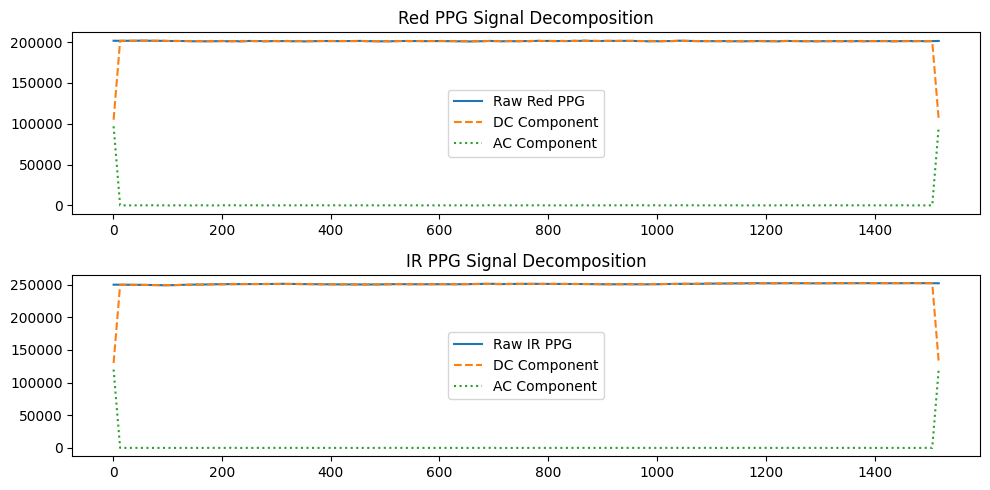

Estimated SpO₂: 84.95%


In [ ]:
import scipy.signal as signal
red_signal = irregular1["red"]
ir_signal = irregular1["IR"]
fs = 25
window_size = 25
t = regular1["sample_index"]
dc_red = np.convolve(red_signal, np.ones(window_size)/window_size, mode='same')
dc_ir = np.convolve(ir_signal, np.ones(window_size)/window_size, mode='same')

# Extract AC component by subtracting DC from original signal
ac_red = red_signal - dc_red
ac_ir = ir_signal - dc_ir

# Plot the components
plt.figure(figsize=(10, 5))
plt.subplot(2,1,1)
plt.plot(t, red_signal, label="Raw Red PPG")
plt.plot(t, dc_red, label="DC Component", linestyle="--")
plt.plot(t, ac_red, label="AC Component", linestyle=":")
plt.legend()
plt.title("Red PPG Signal Decomposition")

plt.subplot(2,1,2)
plt.plot(t, ir_signal, label="Raw IR PPG")
plt.plot(t, dc_ir, label="DC Component", linestyle="--")
plt.plot(t, ac_ir, label="AC Component", linestyle=":")
plt.legend()
plt.title("IR PPG Signal Decomposition")

plt.tight_layout()
plt.show()

# Compute AC/DC ratios
ac_dc_red = np.std(ac_red) / np.mean(dc_red)
ac_dc_ir = np.std(ac_ir) / np.mean(dc_ir)

# Compute SpO2 using empirically derived formula
R = ac_dc_red / ac_dc_ir
SpO2 = 110 - 25 * R

print(f"Estimated SpO₂: {SpO2:.2f}%")

In [226]:
irregular1.head().to_dict()

{'green': {0: 89757, 1: 89298, 2: 89136, 3: 89082, 4: 89131},
 'red': {0: 184937, 1: 184874, 2: 184848, 3: 184842, 4: 184863},
 'IR': {0: 230649, 1: 230568, 2: 230585, 3: 230545, 4: 230598},
 'acc_x': {0: -2.7086751832,
  1: -2.6368905052,
  2: -2.7565316352,
  3: -2.7194428849,
  4: -2.6895326024},
 'acc_y': {0: -8.3533436966,
  1: -8.4095750277,
  2: -8.434699665,
  3: -8.5124663995,
  4: -8.3892360356},
 'acc_z': {0: 3.541377448,
  1: 3.5198420446,
  2: 3.4480573666,
  3: 3.5030922864000003,
  4: 3.5581272062},
 'sample_index': {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}}

In [273]:
def calculate_spo2(data, window_size=50):
  red_values = np.array(list(data['red'].values()))
  ir_values = np.array(list(data['IR'].values()))
  spo2_values = []

  for i in range(len(red_values) - window_size + 1):
    red_window = red_values[i : i + window_size]
    ir_window = ir_values[i : i + window_size]
    dc_red = np.mean(red_window)
    dc_ir = np.mean(ir_window)
    ac_red = np.ptp(red_window)
    ac_ir = np.ptp(ir_window)
    epsilon = 1e-6
    if dc_red < epsilon or dc_ir < epsilon or ac_red < epsilon or ac_ir < epsilon:
      spo2_values.append(None)
      continue
    r = (ac_red / dc_red) / (ac_ir / dc_ir)
    # Clamp R within a reasonable range (adjusted to 0.4 - 1.2)
    r = max(0.4, min(r, 1.2))
    spo2 = np.clip(-40 * (r ** 2) + 35 * r + 100, 0, 100)
    spo2_values.append(spo2)

  spo2_values = scipy.signal.medfilt(spo2_values, kernel_size=5)
  return spo2_values

In [274]:
irregular1.loc[:50,["red", "IR"]].to_dict()

{'red': {0: 184937,
  1: 184874,
  2: 184848,
  3: 184842,
  4: 184863,
  5: 184887,
  6: 184917,
  7: 184955,
  8: 184925,
  9: 184997,
  10: 184985,
  11: 185025,
  12: 185035,
  13: 185089,
  14: 185078,
  15: 185103,
  16: 185137,
  17: 185156,
  18: 185165,
  19: 185068,
  20: 184931,
  21: 184918,
  22: 184824,
  23: 184793,
  24: 184849,
  25: 184869,
  26: 184923,
  27: 184972,
  28: 184953,
  29: 184953,
  30: 184982,
  31: 184986,
  32: 185038,
  33: 185088,
  34: 185079,
  35: 185108,
  36: 185138,
  37: 185131,
  38: 185158,
  39: 185129,
  40: 184952,
  41: 184887,
  42: 184848,
  43: 184832,
  44: 184839,
  45: 184899,
  46: 184938,
  47: 184977,
  48: 185019,
  49: 185044,
  50: 185046},
 'IR': {0: 230649,
  1: 230568,
  2: 230585,
  3: 230545,
  4: 230598,
  5: 230578,
  6: 230645,
  7: 230658,
  8: 230618,
  9: 230646,
  10: 230640,
  11: 230664,
  12: 230672,
  13: 230684,
  14: 230664,
  15: 230650,
  16: 230703,
  17: 230780,
  18: 230718,
  19: 230654,
  20: 230609

In [278]:
spo2_results = calculate_spo2(irregular1.loc[:,["red", "IR"]].to_dict(), window_size=5)
print(np.mean(spo2_results))

85.01320264983414


In [279]:
spo2_results[spo2_results > 90]

array([ 97.96007647,  97.96007647,  97.96007647,  94.31994661,
        94.31994661,  94.31994661,  97.05632455,  97.05632455,
        97.05632455,  99.69877589,  99.69877589,  99.69877589,
        93.59260423,  98.50755231,  98.50755231,  98.50755231,
        97.54549869,  97.54549869,  97.54549869,  90.31978563,
        90.31978563,  90.31978563,  99.86022   , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        ,  99.12909309,  90.91723942,
        90.91723942,  90.91723942,  94.02604161,  94.01596849,
        94.01596849,  94.01596849,  95.13270288,  95.13270288,
        94.82557066, 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        ,  94.60479334,
        94.60479334,  94.60479334,  95.52842251, 100.        ,
       100.        , 100.        ,  95.52842251,  97.48746662,
        97.48746662,  97.48746662,  93.42805785,  93.42

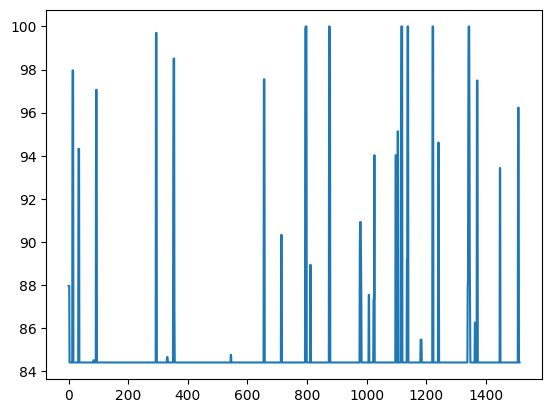

In [277]:
plt.plot(spo2_results)
# plt.hist(np.clip(spo2_results+8+np.random.normal(0, 2, spo2_results.shape[0]), 0, 100))
plt.show()

In [254]:
import scipy
import scipy.signal as signal

for i in os.listdir("/content/drive/MyDrive/TreeHacks2025/ppg_exports_20241126_094919/regular"):
  irregular1 = pd.read_csv("/content/drive/MyDrive/TreeHacks2025/ppg_exports_20241126_094919/regular/" + i)
  red_signal = irregular1["red"]
  ir_signal = irregular1["IR"]
  fs = window_size = 25
  t = irregular1["sample_index"]
  dc_red = np.convolve(red_signal, np.ones(window_size)/window_size, mode='same')
  dc_ir = np.convolve(ir_signal, np.ones(window_size)/window_size, mode='same')

  # Extract AC component by subtracting DC from original signal
  ac_red = red_signal - dc_red
  ac_ir = ir_signal - dc_ir

  def extract_ac_dc_fft(signal, fs):
      """ Extracts AC and DC components from a PPG signal using FFT """
      # Perform FFT
      fft_values = np.abs(scipy.fftpack.fft(signal))
      freqs = scipy.fftpack.fftfreq(len(signal), 1/fs)

      # DC Component: Value at 0 Hz
      dc_component = fft_values[0] / len(signal)

      # AC Component: Find the dominant peak in physiological range (0.5–3 Hz)
      valid_idx = (freqs > 0.5) & (freqs < 3)
      ac_component = np.max(fft_values[valid_idx]) / len(signal)

      return ac_component, dc_component

  # Extract AC/DC components for Red and IR signals
  ac_red, dc_red = extract_ac_dc_fft(red_signal, fs)
  ac_ir, dc_ir = extract_ac_dc_fft(ir_signal, fs)

  # Compute AC/DC ratios
  ac_dc_red = ac_red / dc_red
  ac_dc_ir = ac_ir / dc_ir

  # Compute SpO2 using the empirical formula
  R = ac_dc_red / ac_dc_ir
  SpO2 = 110 - 25 * R

  print(f"Estimated SpO2: {SpO2:.2f}%")

Estimated SpO2: 66.73%
Estimated SpO2: 70.87%
Estimated SpO2: 68.54%
Estimated SpO2: 59.68%
Estimated SpO2: 73.64%
Estimated SpO2: 58.52%
Estimated SpO2: 80.90%
Estimated SpO2: 63.43%
Estimated SpO2: 50.16%
Estimated SpO2: 51.49%
Estimated SpO2: 63.86%
Estimated SpO2: 58.94%
Estimated SpO2: 75.28%
Estimated SpO2: 62.89%
Estimated SpO2: 63.97%
Estimated SpO2: 47.28%
Estimated SpO2: 75.58%
Estimated SpO2: 59.04%
Estimated SpO2: 57.27%
Estimated SpO2: 60.24%
Estimated SpO2: 52.95%
Estimated SpO2: 60.88%
Estimated SpO2: 89.43%
Estimated SpO2: 55.33%
Estimated SpO2: 66.37%
Estimated SpO2: 78.79%
Estimated SpO2: 79.21%
Estimated SpO2: 55.99%
Estimated SpO2: 18.63%
Estimated SpO2: 64.04%
Estimated SpO2: 50.96%
Estimated SpO2: 59.61%
Estimated SpO2: 59.40%
Estimated SpO2: 72.33%
Estimated SpO2: 75.54%
Estimated SpO2: 64.40%
Estimated SpO2: 65.13%
Estimated SpO2: 53.00%
Estimated SpO2: 66.98%
Estimated SpO2: 47.60%
Estimated SpO2: 87.02%
Estimated SpO2: 33.74%
Estimated SpO2: 59.80%
Estimated S

In [ ]:
ir_signal.max() / ir_signal.min()

1.0161951879572075

In [283]:
regular2 = pd.read_csv("/content/drive/MyDrive/TreeHacks2025/ppg_exports_20241126_094919/irregular/irregular_800.csv")
red_signal = regular2["red"]
ir_signal = regular2["IR"]

110 - 25 * (max(red_signal)/min(red_signal)) / (max(ir_signal)/min(ir_signal))

84.89736349649816

In [289]:
v_x, v_y, v_z = 0, 0, 0
pos_x, pos_y, pos_z = 0, 0, 0
xs, ys, zs = [pos_x], [pos_y], [pos_z]
d_x, d_y, d_z = 0, 0, 0
# update_coeff1, update_coeff_2 = 0.1, 0.1
t = 40e-3
for i in range(regular2.shape[0]):
  v_x += t * regular2["acc_x"].iloc[i]
  v_y += t * regular2["acc_y"].iloc[i]
  v_z += t * regular2["acc_z"].iloc[i]

  pos_x += t * v_x
  pos_y += t * v_y
  pos_z += t * v_z
  xs.append(pos_x)
  ys.append(pos_y)
  zs.append(pos_z)

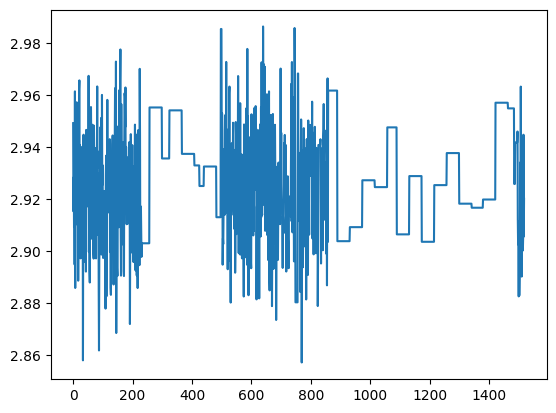

In [357]:
f = np.random.choice(os.listdir("/content/drive/MyDrive/TreeHacks2025/ppg_exports_20241126_094919/unclassified"))

regular2 = pd.read_csv("/content/drive/MyDrive/TreeHacks2025/ppg_exports_20241126_094919/unclassified/" + f)

plt.plot((regular2["acc_x"] ** 2 + regular2["acc_y"] ** 2 + regular2["acc_z"] ** 2) ** 0.5 / 3.28084)
plt.show()

In [301]:
regular2["acc_x"].diff().dropna() / 40e-3

,acc_x
1,-2.033899
2,2.183451
3,-2.721836
4,1.196411
5,-1.495514
...,...
1524,0.000000
1525,0.000000
1526,0.000000
1527,0.000000


-7034.868284863931

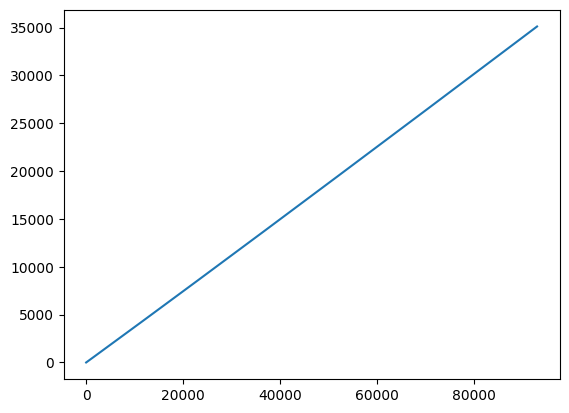

In [ ]:
plt.plot(xs, zs)

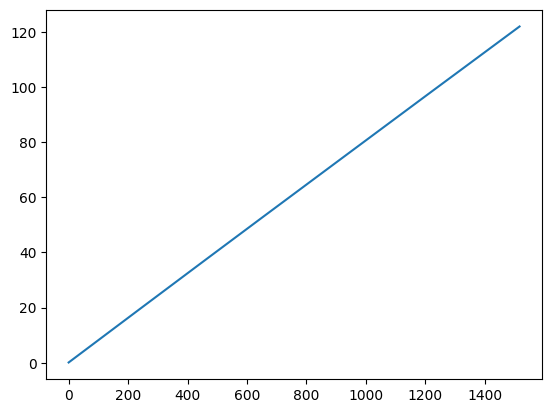

In [ ]:
plt.plot(np.subtract(xs[1:], xs[:-1]))

In [ ]:
np.subtract(xs[1:], xs[:-1])

array([8.08175833e-02, 1.62041946e-01, 2.43589341e-01, ...,
       1.21836413e+02, 1.21915687e+02, 1.21995416e+02])

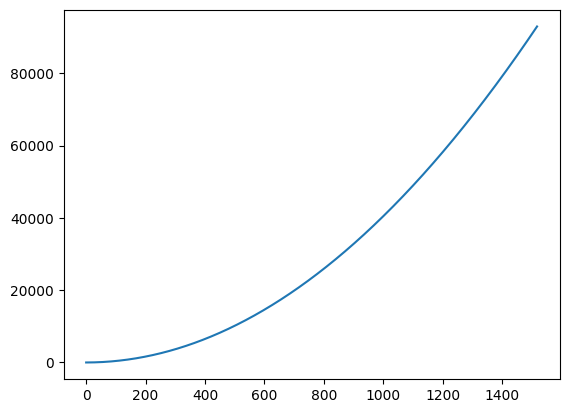

In [ ]:
plt.plot(xs)

<Axes: >

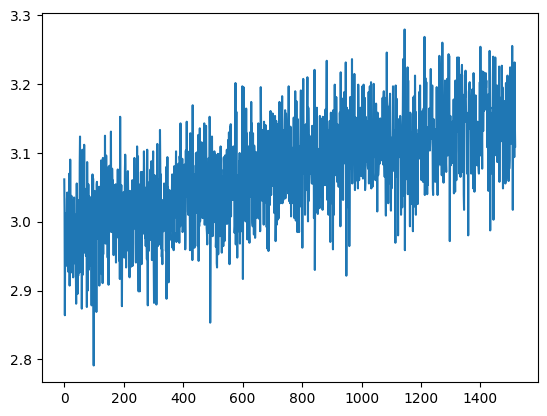

In [ ]:
regular1["acc_z"].plot()

In [ ]:
# Average vector magnitude of movement

In [ ]:
regular1.shape[0]

1518